(sec:othello-agent)=
# オセロAIの作成

ここからは、より高度な強化学習の対象としてオセロを取り扱う。ご存じの通り、オセロは(諸説あるものの)日本で発祥した「はさみ碁」の一種で、白と黒のディスクを8×8の盤の上に並べ、同色で挟まれたディスクを裏返すことで、より多くのマスを獲得した方が勝利するというゲームである。

```{note}
オセロは日本以外ではリバーシのように呼ばれることがある。リバーシは初期状態として、ディスクが置かれていない状態からスタートするが、オセロは盤の中央に白黒2枚ずつのディスクを置いた状態からスタートする、という違いがある。

参考: [オセロ（ボードゲーム）- Wikipedia](https://ja.wikipedia.org/wiki/%E3%82%AA%E3%82%BB%E3%83%AD_(%E3%83%9C%E3%83%BC%E3%83%89%E3%82%B2%E3%83%BC%E3%83%A0))
```

In [1]:
"""
下準備のコード
"""

%load_ext autoreload
%autoreload 2

import time
import random
import contextlib
import multiprocessing

import numpy as np
import joblib
import IPython.display as display
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.animation import ArtistAnimation

matplotlib.rcParams["figure.dpi"] = 200

# 乱数シードの固定
random.seed(12345)
np.random.seed(12345)

# 実験に用いるエピソード数
n_episodes = 1000

# 並列化スレッド数
n_jobs = min(4, multiprocessing.cpu_count() - 2)

In [2]:
try:
    from myst_nb import glue
except:
    glue = lambda _: _

glue("n_episodes", n_episodes, display=False)

In [3]:
# joblib用のtqdm
@contextlib.contextmanager
def tqdm_joblib(total=None, **kwargs):
    pbar = tqdm(total=total, miniters=1, smoothing=0, **kwargs)

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            pbar.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield pbar
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        pbar.close()

## オセロゲーム環境

### オセロモジュールのインストール

今回は、講義用に用意したオセロ用のゲーム環境を用いる。ゲーム環境用のモジュールは以下のURLからダウンロードできる。

<https://github.com/tatsy/1284-sds-ml-advanced/blob/04373681857fa15b89b4b993bf295e2313903d4d/lib/sdsadvml-0.1.0.tar.gz>

ここから`sdsadvml-0.1.0.tar.gz`をダウンロード後、ファイルを展開すると、その中に`setup.py`というファイルが入っている。WindowsならコマンドプロンプトかPowerShell、MacOSならターミナルを開き、以下のAnacondaの仮想環境を切り替えた上で、以下のコマンドを実行するとライブラリがインストールされる。

```shell
python setup.py install
```

### オセロモジュールの概要

このモジュールには大きく分けて、3つのクラスが定義されている。

**Env**はオセロゲームを取り扱う環境で、有効手の列挙や盤の状態の更新などの関数を提供する。ただし、`Env`クラスは直接インスタンス化する代わりに、`gymnasium`と同様に環境作成用の`make`関数が用意されているので、こちらを用いる。

**Move**はオセロゲームにおける「手」を表わすクラスで、現在のプレイヤーとディスクを置く場所を格納している。

**Player**は厳密には列挙型として定義されていて、プレイヤーが黒番なのか白番なのかに加えて、次のプレイヤーに手渡しする関数などが提供されている。

まずは、これらをモジュールからインポートして、ゲーム環境を作成してみる。

In [4]:
# オセロモジュールのインポート
import othello
from othello import Move, Player

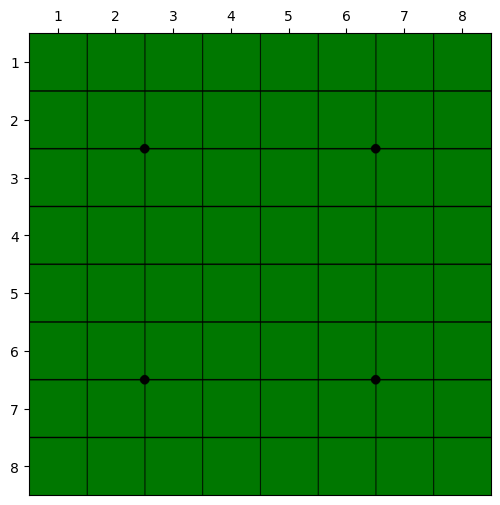

In [5]:
# 環境の作成
env = othello.make()
env

上記のように、オセロ環境は初期状態ではディスクが配置されていない。ここでも`gymnasium`と同様に`reset`関数を呼び出すことで、ゲーム環境が初期化される。

なお、`reset`関数は現在の手番を表わす`player`と、現在の盤面状態を表わすNumPyの配列である`board`を返してくる。この点は`gymnasium`と異なっているので注意すること。

In [6]:
player, board = env.reset()

In [7]:
print(player)

BLACK


In [8]:
print(board)

[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  1 -1  0  0  0]
 [ 0  0  0 -1  1  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]


また、Jupyter Notebook環境においては`env`を表示することで盤面を表わす画像が表示されるようになっている。

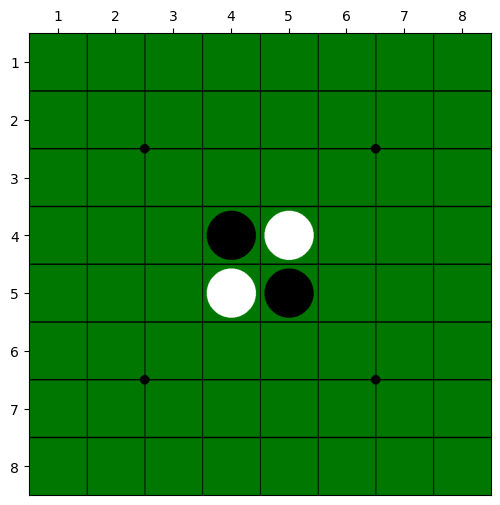

In [9]:
env

## ランダムな着手

まずは、オセロ環境の仕様を理解するために、白番、黒番ともにランダムに行動させて、どのように状態が変化するかを見てみよう。

`env`には、現在の盤の状態で取ることができる「有効手」の配列を取得する`legal_moves`関数が提供されている。

In [10]:
moves = env.legal_moves(player)
print(moves)

[('BLACK', 3, 5), ('BLACK', 4, 6), ('BLACK', 5, 3), ('BLACK', 6, 4)]


上記の出力から、黒番が3行5列、4行6列、5行3列、6行4列の4箇所のいずれかにディスクを置くことができることが分かる。

着手を決定したら、`env.step`関数に手を表わす変数を渡す。`step`関数は`reset`関数と同様に次の手番を表わすプレイヤーと、現在の盤面の状態を返す。

In [11]:
player, board = env.step(moves[0])

In [12]:
print(player)

WHITE


In [13]:
print(board)

[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  0  1  1  0  0  0]
 [ 0  0  0 -1  1  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]


`env`のJupyter Notebook環境における表示により、黒番が3行5列にディスクを置いたことで、着手したセルがハイライトされて、かつ、盤の状態が正しく更新されていることが確認できる。

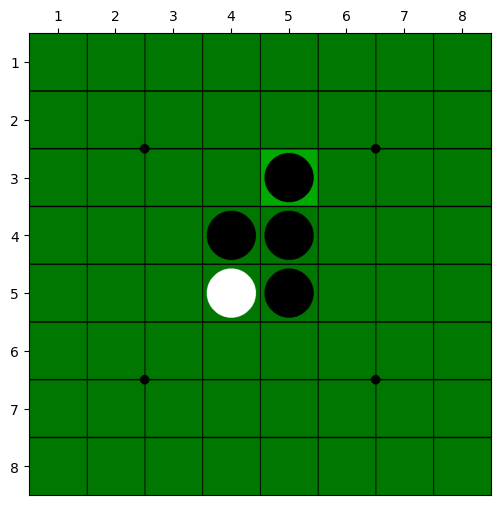

In [14]:
env

オセロはルール上、着手可能な手がない、すなわちどこにディスクを置いても裏返せる相手方のディスクが存在しない時にはパスをすることになる。

有効手が存在しない時には`legal_moves`が空の配列を返してくるので、そのときには`Move.Pass(player)`を呼び出して、パスを表わす「手」を用意する。

```python
moves = env.legal_moves(player)
if len(moves) = 0:
    move = Move.Pass(player)
```

これらを踏まえて、黒番、白番ともにランダムに着手させて、盤の状態変化を確認する。

In [15]:
# ゲームのリセット
player, _ = env.reset()
frames = []

# エピソード開始
while not env.gameset():
    # 有効手の列挙
    moves = env.legal_moves(player)

    # 現在の状態画像を保存
    img = env.render()
    frames.append(img)

    # 着手可能な手があればランダムに1つを選ぶ
    # 選べる手がなければパスする
    if len(moves) != 0:
        move = np.random.choice(moves)
    else:
        move = Move.Pass(player)

    # 着手による盤の状態の更新
    player, _ = env.step(move)

In [16]:
# アニメーションの描画
fig, ax = plt.subplots(figsize=(4, 4), dpi=128)
ax.set(xticks=[], yticks=[])

# 各フレームの描画
draw = []
for i, f in enumerate(frames):
    ims = plt.imshow(f)
    draw.append([ims])

# アニメーションの作成
ani = ArtistAnimation(fig, draw, interval=100, blit=True)
html = display.HTML(ani.to_html5_video())
display.display(html)

# Matplotlibのウィンドウを閉じる
plt.close()

最終的な状態において、黒番、白番がそれぞれ何個のセルを専有しているかは`count`関数により計算できる。

In [17]:
# 黒番、白番の獲得セル数がtuple型で与えられる
print("(black, white) =", env.count())

(black, white) = (27, 37)


In [18]:
# 黒番だけ、白番だけも計算可能
print("#black:", env.count(Player.BLACK))
print("#white:", env.count(Player.WHITE))

#black: 27
#white: 37


最後に、両者ランダムに着手する場合に1000回対戦すると、どの程度の勝敗になるのかを調べてみる。ランダム対戦には少々時間がかかるため、以下のコードでは、`joblib`を用いて、並列実行により同時に複数の対局を行なっている。

In [19]:
def match():
    # ゲームのリセット
    env = othello.make()
    player, _ = env.reset()

    # エピソード開始
    while not env.gameset():
        # 有効手の列挙
        moves = env.legal_moves(player)

        # 着手可能な手があればランダムに1つを選ぶ
        # 選べる手がなければパスする
        if len(moves) == 0:
            move = Move.Pass(player)
        else:
            move = np.random.choice(moves)

        # 着手による盤の状態の更新
        player, _ = env.step(move)

    return env.count()


with tqdm_joblib(n_episodes):
    result = joblib.Parallel(n_jobs=n_jobs)(
        (joblib.delayed(match)() for _ in range(n_episodes)),
    )

result = np.array(result, dtype="int32")
b_win = np.sum(result[:, 0] > result[:, 1])
w_win = np.sum(result[:, 0] < result[:, 1])
draw = np.sum(result[:, 0] == result[:, 1])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
glue("rand_b_win", b_win, display=False)
glue("rand_w_win", w_win, display=False)
glue("rand_draw", draw, display=False)

**対局結果: ランダム vs ランダム**
- 黒番勝ち: {glue:}`rand_b_win`
- 白番勝ち: {glue:}`rand_w_win`
- 引き分け: {glue:}`rand_draw`

このようにランダムな着手では当然ながら、勝率はおよそ五分五分になる。ただし、オセロは後手である白番の方が若干有利であると言われており、ランダムに着手した場合には白番の勝率がやや高くなっている。

以後は、この着手の方法を改良していき、より高い勝率を目指してみる。以下、利便性のために、ランダムに着手する関数として`move_by_random`を作成しておく。

In [21]:
def move_by_random(env, player):
    """有効手の中からランダムに手を選ぶ"""
    moves = env.legal_moves(player)
    if len(moves) == 0:
        return Move.Pass(player)
    else:
        return np.random.choice(moves)

:::{admonition} オセロが解けた？
:class: note

2023年10月に「Othello is Solved」という衝撃的なタイトルの論文が、プレプリント投稿サイトのarXivに公開された。この論文は、オセロゲームが「弱解決」したことを示している論文で、「弱解決」とは両対局者が常に最善の手を指し続けると、結果がどうなるかが解析できたことを示す。

人間の体感としては後手の方が(最後にディスクをおけるという意味で)若干有利のように感じるが、この論文によれば、オセロは、**両者が最善手を指し続けると引き分けになる**そうだ。興味のある読者は是非、以下の原著を読んでみてほしい。

Othello is Solved: <https://arxiv.org/abs/2310.19387>
:::

## セル評価値を用いた着手

人間(の初心者)がオセロを指すときに最初に覚えることと言えば、角が取れるように着手を調整する、ということだろう。

角のセルは一度ディスクを置いてしまえば、それ以降、相手に取られることがなく、また縁の領域にあるディスクを一度に多くひっくり返すこともできるため、角にディスクを置くことができれば有利になることが多い。

一方で、角のセルに隣接するセルにディスクを置くと、相手に角を取られる可能性が出てくるので、角に隣接するセルにはできる限りディスクを置かない方が良いことが分かる。

このような人間の経験則に従って、各セルにディスクを置くことが、どのくらい得でどのくらい損なのかを表わす評価値を以下のように定義する。

In [22]:
scores = np.array(
    [
        [120, -20, 20, 5, 5, 20, -20, 120],
        [-20, -40, -5, -5, -5, -5, -40, -20],
        [20, -5, 15, 3, 3, 15, -5, 20],
        [5, -5, 3, 0, 0, 3, -5, 5],
        [5, -5, 3, 0, 0, 3, -5, 5],
        [20, -5, 15, 3, 3, 15, -5, 20],
        [-20, -40, -5, -5, -5, -5, -40, -20],
        [120, -20, 20, 5, 5, 20, -20, 120],
    ],
    dtype="int32",
)

In [23]:
fig, ax = plt.subplots()

ax.set_xticks(np.arange(0, 8))
ax.set_yticks(np.arange(0, 8))
ax.set_xticklabels(np.arange(1, 9))
ax.set_yticklabels(np.arange(1, 9))

ax.set_xticks(np.arange(1, 9) - 0.5, minor=True)
ax.set_yticks(np.arange(1, 9) - 0.5, minor=True)

ax.imshow(scores, cmap="tab20", interpolation=None)
for (i, j), z in np.ndenumerate(scores):
     txt = ax.text(j, i, "{:d}".format(z), ha="center", va="center", color="k", fontsize=15)

ax.grid(which="minor", color="k", linestyle="-", linewidth=0.5)

glue("cell_scores", fig, display=False)
plt.close()

```{glue:figure} cell_scores
:figwidth: 512px
:name: "オセロ盤のセル評価値"
```

In [24]:
def move_by_score(env, player):
    """セル評価値を用いた着手"""
    moves = env.legal_moves(player)
    if len(moves) == 0:
        return Move.Pass(player)
    else:
        # 有効手の中で最も評価値が高いセルに着手する
        best_move = moves[0]
        best_score = -99999
        for move in moves:
            score = scores[move.x, move.y]
            if best_score < score:
                best_move = move
                best_score = score

        return best_move

このルーチンを用いて、先ほどと同様に{glue:}`n_episodes`回の対戦を行ない、ランダムな着手に比べて、どのくらい勝率が上昇するかを見てみよう。

In [25]:
def match():
    # ゲームのリセット
    env = othello.make()
    player, _ = env.reset()

    # エピソード開始
    while not env.gameset():
        # 黒番:
        if player == Player.BLACK:
            # セル評価値が最も高い場所に着手する
            move = move_by_score(env, player)
        # 白番:
        if player == Player.WHITE:
            # 着手可能な手があればランダムに1つを選ぶ
            move = move_by_random(env, player)

        # 着手による盤の状態の更新
        player, _ = env.step(move)

    return env.count()


with tqdm_joblib(n_episodes):
    result = joblib.Parallel(n_jobs=n_jobs)(
        (joblib.delayed(match)() for _ in range(n_episodes)),
    )

result = np.array(result, dtype="int32")
b_win = np.sum(result[:, 0] > result[:, 1])
w_win = np.sum(result[:, 0] < result[:, 1])
draw = np.sum(result[:, 0] == result[:, 1])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [26]:
glue("score_b_win", b_win, display=False)
glue("score_w_win", w_win, display=False)
glue("score_draw", draw, display=False)

**対局結果: セル評価値 vs ランダム**
- 黒番勝ち: {glue:}`score_b_win`
- 白番勝ち: {glue:}`score_w_win`
- 引き分け: {glue:}`score_draw`

上記の通り、人間の経験則を導入することでランダムに着手するのと比べて大幅に勝率が上昇していることが分かる。

(ssec:minimax)=
## ミニマックス探索

上記のセル評価値に基づく着手では、今まさに打とうとしている手が、**その時点においてどのくらいの価値を持つのか**だけを考慮していた。

しかし、実際には、局面によっては、角に単にセルの評価値が高いディスクに置くよりも、その後、何手か指した後に、より勝ちの高い手が打てるような手も存在するだろう。

実際に人間がオセロをプレイするときも、ある程度は「次に相手が何を」してくるかを考えているはずで、その際、**できるだけ自分に得**で**できるだけ相手に損**な手を指すのが良いと考えるだろう。

このような考え方に基づいて、手を先読みして着手を探索する手法に**ミニマックス探索**がある (min-max探索ではないので注意)。

In [27]:
def minimax(env, move, depth, max_depth):
    next_player, _ = env.step(move)

    if depth >= max_depth:
        score = move.player * np.sum(env.board * scores)
    else:
        # 相手にとってのベストスコアを計算
        best_score = -99999
        for next_move in env.legal_moves(next_player):
            score = minimax(env, next_move, depth + 1, max_depth)
            if best_score < score:
                best_score = score

        # 自分にとっては相手のベストスコアは小さい方が良い
        score = -best_score

    env.undo()
    return score

In [28]:
def move_by_minimax(env, player, max_depth=2):
    moves = env.legal_moves(player)
    if len(moves) == 0:
        return Move.Pass(player)

    best_move = moves[0]
    best_score = -99999
    for move in moves:
        score = minimax(env, move, 0, max_depth)
        if best_score < score:
            best_move = move
            best_score = score

    return best_move

In [29]:
def match():
    # ゲームのリセット
    env = othello.make()
    player, board = env.reset()

    # エピソード開始
    while not env.gameset():
        # 黒番:
        if player == Player.BLACK:
            # ミニマックス探索
            move = move_by_minimax(env, player, 2)
        # 白番:
        if player == Player.WHITE:
            # セル評価値に基づく着手
            move = move_by_random(env, player)

        # 着手による盤の状態の更新
        player, _ = env.step(move)

    return env.count()


with tqdm_joblib(n_episodes):
    result = joblib.Parallel(n_jobs=n_jobs)(
        (joblib.delayed(match)() for _ in range(n_episodes)),
    )

result = np.array(result, dtype="int32")
b_win = np.sum(result[:, 0] > result[:, 1])
w_win = np.sum(result[:, 0] < result[:, 1])
draw = np.sum(result[:, 0] == result[:, 1])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [30]:
glue("minimax_b_win", b_win, display=False)
glue("minimax_w_win", w_win, display=False)
glue("minimax_draw", draw, display=False)

**対局結果: ミニマックス vs ランダム**
- 黒番勝ち: {glue:}`minimax_b_win`
- 白番勝ち: {glue:}`minimax_w_win`
- 引き分け: {glue:}`minimax_draw`

上記の通り、ミニマックス探索で2手先を読むだけで飛躍的に勝率が上昇していることが分かる。

ただし、ミニマックス探索は再帰的に手を探索するため、より多くの手を読もうとすると、かなり多くの時間を要する。実際、ミニマックス探索は「本来探索する必要のない手」も探索しているがために、余計に計算を行なっている。

ミニマックス探索は、現在の局面から先の手を読むときに、相手も自分自身に取って最善となるように手を検討する。そのため、相手の手の評価値は検討を進めるに従って**相手にとっての価値は上昇していく**一方で、**自分にとっての価値は減少していく**ことが分かる。

従って、今得られている価値が最大の手の評価値より、相手の手の探索中に得られる評価値が小さくなった瞬間に、それ以上手を探索する必要がなくなる。このような原理に基づいて探索の枝刈りを行なう手法に**アルファベータ探索**がある。

アルファベータ探索は上記の`minimax`関数を少し改良するだけで実装できるので、練習問題として取り組んでみて、探索の効率が上昇することを確認してほしい。

(ssec:monte-carlo)=
## 原始モンテカルロ探索

In [31]:
def playout(env, move, n_trials):
    oppo, board = env.step(move)
    n_moves = len(env.history)

    score = 0
    for _ in range(n_trials):
        player = oppo
        env.board = board
        env.history = env.history[:n_moves]
        env.stack = env.stack[:n_moves]

        while not env.gameset():
            next_move = move_by_random(env, player)
            player, _ = env.step(next_move)

        if env.count(move.player) > env.count(oppo):
            score += 1

    env.undo()

    return score

In [32]:
def move_by_monte_carlo(env, player, n_trials=4):
    moves = env.legal_moves(player)
    if len(moves) == 0:
        return Move.Pass(player)

    best_move = moves[0]
    best_score = 0
    for move in moves:
        score = playout(env, move, n_trials)
        if best_score < score:
            best_move = move
            best_score = score

    return best_move

In [33]:
def match():
    # ゲームのリセット
    env = othello.make()
    player, board = env.reset()

    # エピソード開始
    while not env.gameset():
        # 黒番:
        if player == Player.BLACK:
            # 原始モンテカルロ探索
            move = move_by_monte_carlo(env, player)
        # 白番:
        if player == Player.WHITE:
            # 着手可能な手があればランダムに1つを選ぶ
            move = move_by_random(env, player)

        # 着手による盤の状態の更新
        player, _ = env.step(move)

    return env.count()


with tqdm_joblib(n_episodes):
    result = joblib.Parallel(n_jobs=n_jobs)(
        (joblib.delayed(match)() for _ in range(n_episodes)),
    )

result = np.array(result, dtype="int32")
b_win = np.sum(result[:, 0] > result[:, 1])
w_win = np.sum(result[:, 0] < result[:, 1])
draw = np.sum(result[:, 0] == result[:, 1])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [34]:
glue("mc_b_win", b_win, display=False)
glue("mc_w_win", w_win, display=False)
glue("mc_draw", draw, display=False)

**対局結果: ミニマックス vs ランダム**
- 黒番勝ち: {glue:}`mc_b_win`
- 白番勝ち: {glue:}`mc_w_win`
- 引き分け: {glue:}`mc_draw`

## 練習問題

- 本文中に示した`minimax`関数を改良して、アルファベータ探索を実装せよ。